In [66]:
import pylab # import *
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import numpy as np
import math


####################################################################
####################################################################

ro7 = 2.6989 #g/cm^3
classic_electr_radius = 2.817940*10**-13 # cm
M7 = 26.98 # g/mol
N_Avogadro = 6. * 10 ** 23 # mol^-1
numberOfAtoms = ro7 / M7 * N_Avogadro
h_Planck = 6.582 * 10 ** -19 #eV*s
c_light = 3. * 10 ** 10 
hbarc = h_Planck*c_light
twopi = 2*np.pi
all = ro7 / M7 * N_Avogadro * hbarc * 10 ** -24 * 44.8
fElectronDensity = 13*numberOfAtoms

const =  44.8/(4*np.pi*classic_electr_radius*hbarc)* 10 ** -24 * ro7 / M7 * N_Avogadro 

def read(address):
    energy = []
    RealPart = []
    ImagePart = []

    lAtt = []
    with open(address) as f:
        for line in f:
            data = list(map(float, line.split()))
            energy.append(data[0]/1000)
            RealPart.append(1+data[1])
            ImagePart.append(data[2])
    return energy, RealPart, ImagePart

def readRefractive(address):
    energy = []
    RealPart = []
    ImagePart = []

    lAtt = []
    with open(address) as f:
        for line in f:
            data = list(map(float, line.split()))
            energy.append(data[0]/1000)
            RealPart.append(data[1])
            ImagePart.append(data[2])
    return energy, RealPart, ImagePart

import math

class G4PAIxSection:

    coef = [[ 0.01, -1.654E+4, 1.585E+2, 3.907, -3.383E-2 ] ,
        [ 0.0159,  0.9500E+3,  -4.015E+1, 6.623E-1,   -2.813E-3 ] ,
        [ 0.0726,  2.490E+4, -7.953E+2, -7.978E+1,  1.974  ] ,
        [ 0.1317, -3.284E+2, 1.499E+3,   4.360E+2,   -4.747E+1  ] ,
        [ 1.56,   -3.674,  -1.622*10, 2.732*10**4,   -1.752*10**4 ] ,
        [ 20.0,    0.4158, -0.1351*10**3,  0.2716*10**5,  0.3723*10**3 ] ,
        [ 100.0,   0.1125*10**-1,  0.2747*10**1,  0.1174*10**5,  0.5695*10**6 ] ,
        [ 500.0,   0.8505*10**-2,  0.1049*10**2,  0.4429*10**4,  0.2431*10**7 ]]

    
    def AbsorptionCoefficient2(self, energy1):
        #energy1 *= 10**-3
        #AoverAvo = 1E-4 / (classic_electr_radius * hbarc * 4 * np.pi)
        #energy2 = energy1**2
        #energy3 = energy1**3
        #energy4 = energy1**4
        result = np.zeros_like(energy1)
        for i in range(0, len(self.coef)-1):
            mask = (energy1 > self.coef[i][0]) & (energy1 <= self.coef[i + 1][0])
            result[mask] = self.coef[i][1] / energy1[mask] + self.coef[i][2] / energy1[mask]**2 + self.coef[i][3] / energy1[mask]**3 + self.coef[i][4] / energy1[mask]**4
        return result
    
    def ImPartScatteringFactor(self, energy1):
        const = 2*classic_electr_radius*2*np.pi*hbarc*10**24/44.8
        result = energy1 * self.AbsorptionCoefficient2(energy1)/const
        return result


    def RePartScatteringFactor(self, enb):
        res = np.zeros_like(enb)
        
        resNorm = np.zeros_like(enb)
        resPole = np.zeros_like(enb)
        fIntervalI2 = np.zeros_like(enb)
        fIntervalIPlus2 = np.zeros_like(enb)
        enb2 = enb**2
        const = 1/(2*classic_electr_radius*np.pi*np.pi*hbarc*10**24/44.8)
        #AoverAvo = 1E-4 / (classic_electr_radius * hbarc * 2 * math.pi**2)
        for j in range(enb.size):
            for i in range(1, 7):
                if i == 7:
                    fEnergyIntervalPlus = 1E+20
                else:
                    fEnergyIntervalPlus = self.coef[i+1][0]
                fEnergyInterval = self.coef[i][0]
                fIntervalI2 = self.coef[i][0]**2
                fIntervalIPlus2 = self.coef[i+1][0]**2
            
                # Looking for an interval having a pole and integrate it
                if((enb[j] > self.coef[i][0]) and (enb[j] <= self.coef[i+1][0])):
                    resPole[j] = self.coef[i][1] / 2 * np.log((-enb2[j] + fIntervalI2) / (enb2[j] - fIntervalIPlus2))
                    resPole[j] += self.coef[i][2] / (2 * enb[j]) * np.log((enb[j] + fEnergyIntervalPlus) * (-enb[j] + fEnergyInterval) / (enb[j] - fEnergyIntervalPlus) / (enb[j] + fEnergyInterval))
                    resPole[j] += self.coef[i][3] / (2 * enb2[j]) * (np.log(fIntervalIPlus2 / fIntervalI2) + np.log((-enb2[j] + fIntervalI2) / (enb2[j] - fIntervalIPlus2)))
                    resPole[j] += self.coef[i][4] / enb2[j] * ((1 / (fEnergyInterval) - 1 / (fEnergyIntervalPlus)) + 1 / (2 * enb[j]) * np.log((enb[j] + fEnergyIntervalPlus) * (-enb[j] + fEnergyInterval) / (enb[j] - fEnergyIntervalPlus) / (enb[j] + fEnergyInterval)))
                    res[j] += resPole[j]
                else:
                    resNorm[j] = self.coef[i][1] / 2 * np.log((enb2[j] - fIntervalI2) / (enb2[j] - fIntervalIPlus2))
                    resNorm[j] += self.coef[i][2] / (2 * enb[j]) * np.log((enb[j] + fEnergyIntervalPlus) * (enb[j] - fEnergyInterval) / (enb[j] - fEnergyIntervalPlus) / (enb[j] + fEnergyInterval))
                    resNorm[j] += self.coef[i][3] / (2 * enb2[j]) * (np.log(fIntervalIPlus2 / fIntervalI2) + np.log((enb2[j] - fIntervalI2) / (enb2[j] - fIntervalIPlus2)))
                    resNorm[j] += self.coef[i][4] / enb2[j] * ((1 / (fEnergyInterval ) - 1 / (fEnergyIntervalPlus)) + 1 / (2 * enb[j]) * np.log((enb[j] + fEnergyIntervalPlus) * (enb[j] - fEnergyInterval) / (enb[j] - fEnergyIntervalPlus) / (enb[j] + fEnergyInterval)))
                    res[j] += resNorm[j]
                    #print('resNorm',resNorm)
            #print(mask, enb)
            #print('res',res)
        res = 13 - (13 / 82.5)**2.37 + res * const;
        #res = res * const
        return res;


    def ImPartRefractiveIndex(self, energy1):
        coeff = classic_electr_radius * hbarc * hbarc / twopi * numberOfAtoms*4*np.pi**2
        result = coeff * self.ImPartScatteringFactor(energy1) / (energy1 * energy1)
        return result


    def RePartRefractiveIndex(self, energy1):
        coeff = classic_electr_radius * hbarc * hbarc / twopi * numberOfAtoms*4*np.pi**2
        result = coeff * self.RePartScatteringFactor(energy1) / energy1 / energy1
        return 1-result
    
    def ImPartPermittivity(self, energy1):
        return 2*self.RePartRefractiveIndex(energy1)*self.ImPartRefractiveIndex(energy1)
    
    def RePartPermittivity(self, energy1):
        return self.RePartRefractiveIndex(energy1)*self.RePartRefractiveIndex(energy1) - self.ImPartRefractiveIndex(energy1)*self.ImPartRefractiveIndex(energy1) 

geant = G4PAIxSection ()
    


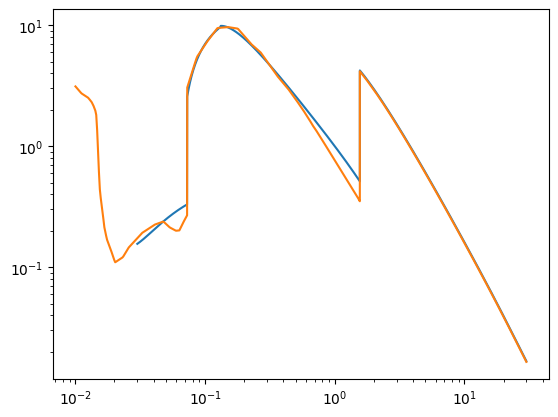

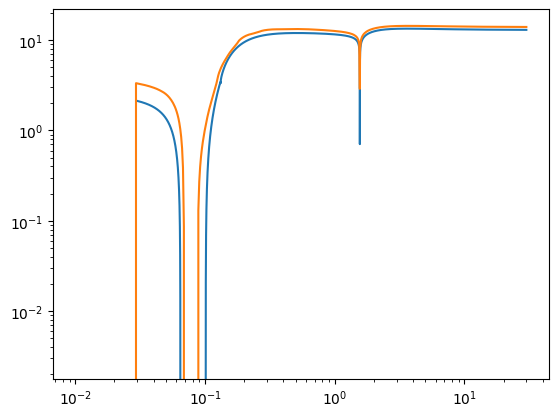

In [20]:
en, re, im = read('/home/boris/Документы/scattering_factor')
xx1 = np.linspace(0.03, 30, 500000, endpoint=True);


plt.loglog(xx1, geant.ImPartScatteringFactor(xx1))
plt.loglog(en, im)

plt.figure()
plt.loglog(xx1, geant.RePartScatteringFactor(xx1))
plt.loglog(en, re)

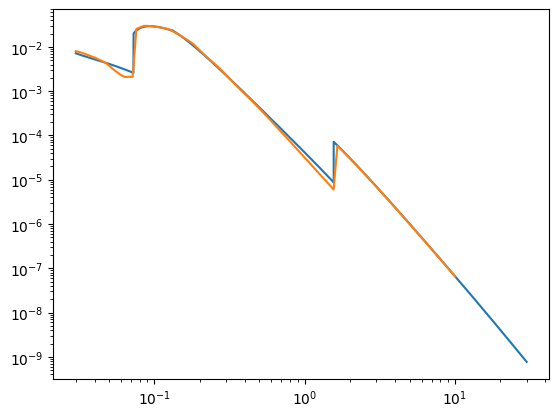

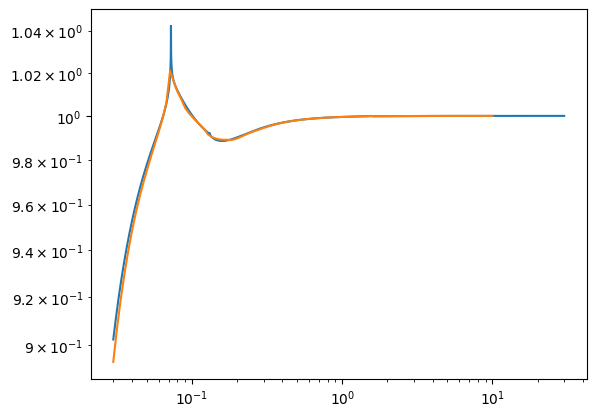

In [67]:
enn, ren, imn = readRefractive('/home/boris/Документы/refractive_index')
imn = np.array(imn)
ren = 1-np.array(ren)
plt.loglog(xx1, geant.ImPartRefractiveIndex(xx1))
plt.loglog(enn, imn)

plt.figure()
plt.loglog(xx1, geant.RePartRefractiveIndex(xx1))
plt.loglog(enn, ren)

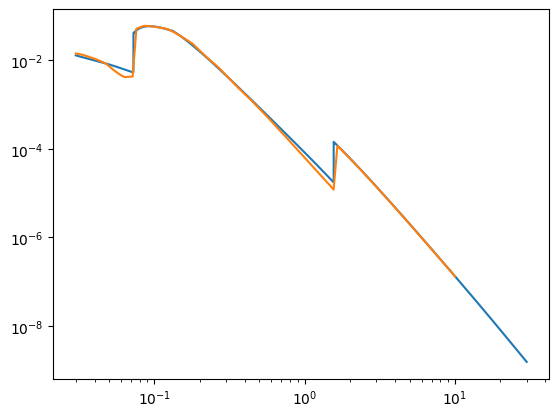

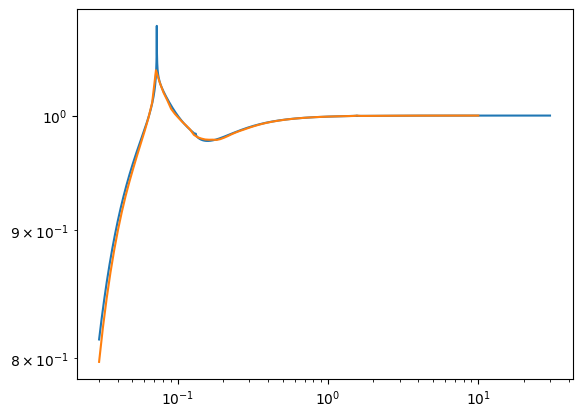

In [69]:
plt.loglog(xx1, geant.ImPartPermittivity(xx1))
plt.loglog(enn, 2*imn*ren)

plt.figure()
plt.loglog(xx1, geant.RePartPermittivity(xx1))
plt.loglog(enn, ren*ren-imn*imn)